# Data Challeng 2 - Yammer
## Overview
The product manager of the group wants to investigate a drop i user engagement in the last month.The timeseries diagram shows a constant trend from the second week of may until the start of Aug, then a sudden change in the trend sign. The initial observations include the following:
* The change is very sudden. Therefore it more seems to be similar to a chatastrophic event that has suddenly caused the change. Such as a progressing break down in the servers  that continuously has stopped service to growing number of customers
* Another possibility might be related to the human groups or communities. For example an important business customer has decided to swith into another platform, e.g. Slack, and starting August the employees have started to switch into the other platform. Or it might be people from a community with a specific lenguage might have started to switch to a similar product which supports their language.

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import pandas as pd
import datetime
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import pickle


In [49]:
# Defining a parser for reading in the date fields in an appropriate format and type
mydateparser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

# Reading all tables
df_user = pd.read_csv('data_yammer/yammer_users.csv', parse_dates=["created_at"], date_parser=mydateparser, dtype = {'user_id': int, 'company_id': int})
df_events = pd.read_csv('data_yammer/yammer_events.csv', parse_dates=["occurred_at"], date_parser=mydateparser, dtype = {'user_id': int})
df_emails = pd.read_csv('data_yammer/yammer_emails.csv', parse_dates=["occurred_at"], date_parser=mydateparser)
df_rollup = pd.read_csv('data_yammer/dimension_rollup_periods.csv', parse_dates=['time_id', 'pst_start', 'pst_end', 'utc_start', 'pst_start'],
                        date_parser=mydateparser)


In [50]:
# Cleaning data
# Based on the problem definition we are only looking into engagement type events
df_events = df_events[df_events['event_type']=='engagement']  


## Exploratory Data Analysis
Looking into users data shows that 19066 users do not have activation dates

* Looking into the distribution of employees for different companies

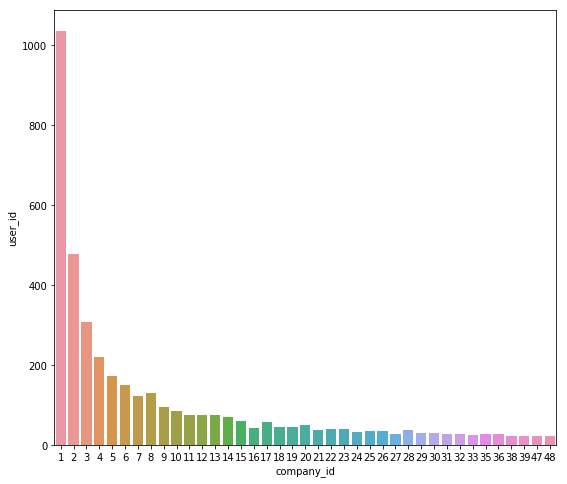

In [51]:
# counting the number of users in each company
a = df_user.groupby('company_id').count()['user_id']
a = a[a>20]    # there are a few thousand companies. let's keep the big plyers
plt.figure(figsize=(9, 8))
sns.barplot(a.index, a)

#emp_lang = df_user.groupby('language').count()
#plt.figure(figsize=(9, 8))
#sns.barplot(emp_lang.index, emp_lang['user_id'])

As seen in figure above, the distribution of the company sizes follows a power law distribution. If I want to draw any conclusion regarding the company wide changes in user behavior I will just look into the first 10 companies with the following number of users

In [52]:
a[:10]

company_id
1     1036
2      477
3      307
4      220
5      172
6      151
7      122
8      129
9       96
10      86
Name: user_id, dtype: int64

What if users with some similar characteristics have started a change in their behavior? Let's take a look at how the languages of users are disperced.

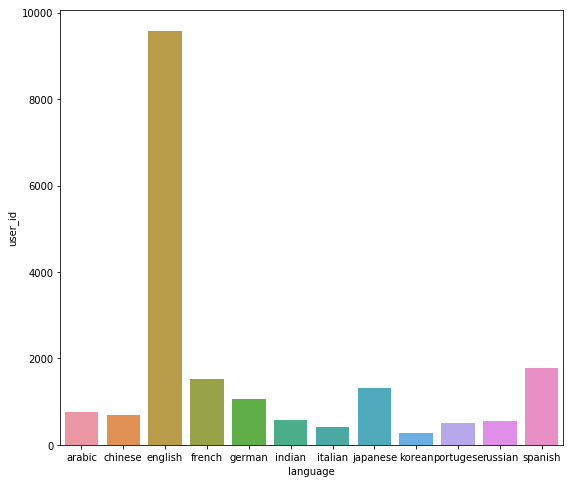

In [53]:
emp_lang = df_user.groupby('language').count()
plt.figure(figsize=(9, 8))
sns.barplot(emp_lang.index, emp_lang['user_id'])

English language speakers by far are the most number of users. Considering this we can probably add all others into one category named 'Non-english'. That can make calculations easier and better to undrestand

### Looking into the timeseries of different features
It will be very informative to look into the time series diagrams of different features and see if we can find any similarity in their behavior with the user activity diagram. In the follow I have plotted these timeseries for a few of features.

In [54]:
# Joining tables to create timeseries for different features
# df_user_events = df_user.join(df_events, on='user_id', how='right')
df_user_events = pd.merge(df_user, df_events, on='user_id')
df_user_events['occurred_at'] = df_user_events['occurred_at'].dt.date
df_user_events.head(3)

In [55]:
# I want to see different time series based on different parameters
# Based on event name
#ts_event_name = df_user_events.groupby(['event_name', 'occurred_at'])

# reset_index() gives a column for counting, after groupby uses year and category
ctdf = (df_user_events.reset_index().groupby(['occurred_at', 'event_name'], as_index=False)
          .count()
          # rename isn't strictly necessary here, it's just for readability
          .rename(columns={'index':'ct'})
       )

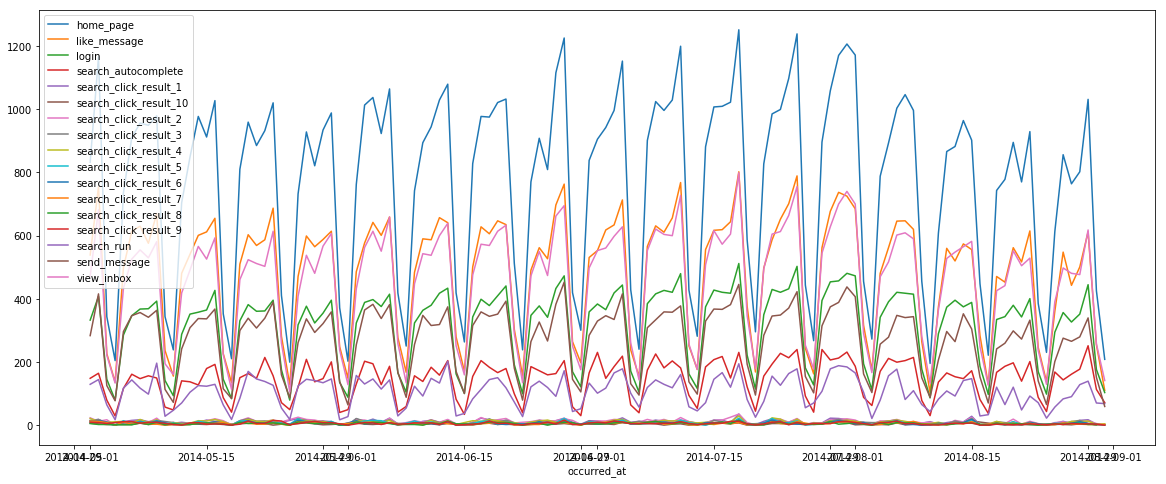

In [56]:
#from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(20, 8))
#plt.figure(figsize=(20,20))
# key gives the group name (i.e. category), data gives the actual values
for key, data in ctdf.groupby('event_name'):
    data.plot(x='occurred_at', y='ct', ax=ax, label=key)


A very clear similar trend, both in the direction and in the change point, can be seen in the first 5 event_names, which are "home_page", 

/anaconda3/envs/labx/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


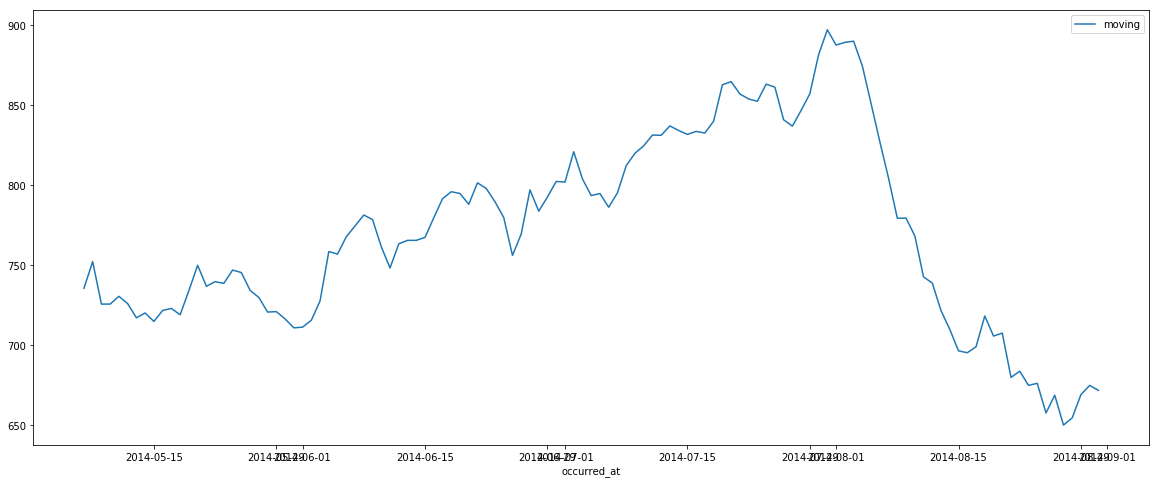

In [58]:
# Creating the 7 day moving average for the most important event of 'home_page'
sample = ctdf[ctdf['event_name']=='home_page']
sample['moving'] = sample['ct'].rolling(7).mean()

fig, ax = plt.subplots(figsize=(20, 8))
#plt.figure(figsize=(20,20))
# key gives the group name (i.e. category), data gives the actual values
sample.plot(x='occurred_at', y='moving', ax=ax)

The above diagram clearly shows that how the number of occurences for this specific, highest used event, has started an abrupt and fast decline. It is very similar to the user activity diagram time series.

## Conclusion
The graphs, show that there is a correlation in the time series of some specific events and the diagram of question. One method can be adding all these high impact features into a set and perform a random forst or linear regression model to find out the reasons causing this problem